**1. Встановлення середовища:**
  * Встановіть необхідні бібліотеки: TensorFlow або PyTorch, numpy, matplotlib, OpenCV (для обробки зображень).
  * Підготуйте обчислювальне середовище з GPU для швидшого навчання, якщо можливо.

In [11]:
import random
import argparse
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import pickle as pkl
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset, Dataset, DataLoader
from torch.autograd import Variable
from torchvision.models import vgg19
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import itertools
import math
import os
import zipfile
import shutil
from PIL import Image
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

In [12]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
torch.cuda.empty_cache()

**2. Вибір та підготовка набору даних:**
  * Виберіть набір даних для відновлення зображень, наприклад, CelebA (для облич) або інший датасет зображень.
  * Підготуйте навчальні приклади: створіть зменшені або пошкоджені версії зображень для тренування GAN (наприклад, зменшення роздільної здатності, розмиття або додавання шуму).

In [39]:
# Гіперпараметри
batch_size = 16
num_epochs = 10
beta1 = 0.5
beta2 = 0.999
lr = 2e-4
torch.manual_seed(42)
np.random.seed(42)
hr_height = 256
hr_width = 256
hr_shape = (hr_height, hr_width)
n_cpu = 8
sample_interval = 10
sample_size = 1000  # Кількість рандомних зображень

In [40]:
#Створюємо папки
# !rm -rf './data/saved_models/'
# !rm -rf './data/result/'
# !rm -rf './data/images/'

**Local upload**


In [41]:
# 1. Шляхи
zip_path = './sample_data/img_align_celeba.zip'
extract_path = './data/img_align_celeba/'

# 2. Розархівування
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall('./data')

# 3. Видалення .ipynb_checkpoints
for root, dirs, files in os.walk(extract_path):
    for dir_name in dirs:
        if dir_name == '.ipynb_checkpoints':
            shutil.rmtree(os.path.join(root, dir_name))

# 4. Створення підкаталогу
default_class_path = os.path.join(extract_path, 'default_class')
if not os.path.exists(default_class_path):
    os.makedirs(default_class_path)
    for file_name in os.listdir(extract_path):
        file_path = os.path.join(extract_path, file_name)
        if os.path.isfile(file_path):  # Перевірка, чи це файл
            shutil.move(file_path, os.path.join(default_class_path, file_name))


# Створення додаткових папок
!mkdir './data/images'
!mkdir './data/saved_models'
!mkdir './data/result'
!mkdir './data/saved_models/result'

mkdir: cannot create directory ‘./data/images’: File exists
mkdir: cannot create directory ‘./data/saved_models’: File exists
mkdir: cannot create directory ‘./data/result’: File exists
mkdir: cannot create directory ‘./data/saved_models/result’: File exists


In [42]:
class ImageDataset(Dataset):
    def __init__(self, root, hr_shape, sample_size=None):
        hr_height, hr_width = hr_shape

        all_files = sorted(glob.glob(root + "/*.*"))
        # self.files = sorted(glob.glob(root + "/*.*"))

        # select random image
        if sample_size and len(all_files) > sample_size:
            self.files = random.sample(all_files, sample_size)
        else:
            self.files = all_files

        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height // 4, hr_height // 4), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((hr_height, hr_height), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
            ]
        )

        #self.files = sorted(glob.glob(root + "/*.*"))

    def __getitem__(self, index):
        img = Image.open(self.files[index % len(self.files)])
        img_lr = self.lr_transform(img)
        img_hr = self.hr_transform(img)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.files)

In [43]:
dataloader = DataLoader(
    ImageDataset('./data/img_align_celeba/default_class/', hr_shape=hr_shape, sample_size = sample_size),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_cpu
)

In [50]:
print(f"Length dataset: {len(dataloader.dataset)}")
print(f"Length dataloader: {len(dataloader)}")

Length dataset: 1000
Length dataloader: 63


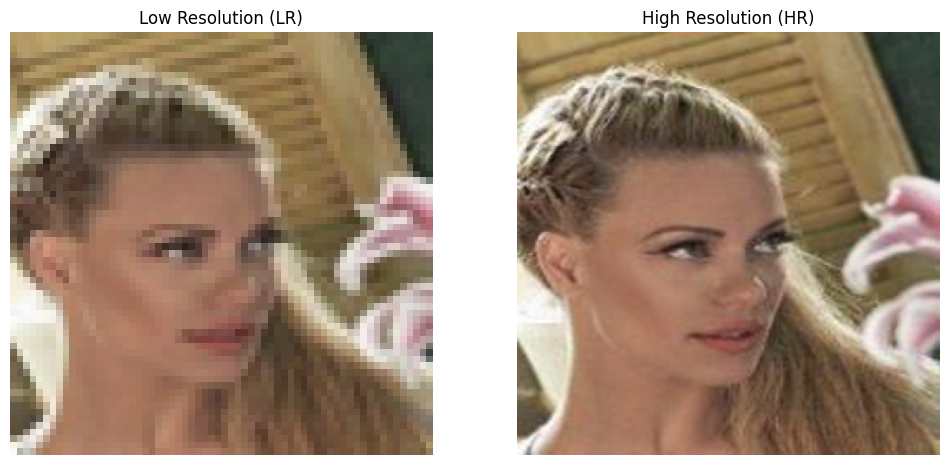

In [45]:
import matplotlib.pyplot as plt
import numpy as np

sample = dataloader.dataset[0] #first element

lr_image = sample['lr']
hr_image = sample['hr']

lr_image_np = (lr_image.numpy() + 1) / 2
hr_image_np = (hr_image.numpy() + 1) / 2

# Transform (H, W, C)
lr_image_np = np.transpose(lr_image_np, (1, 2, 0))
hr_image_np = np.transpose(hr_image_np, (1, 2, 0))


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Low Resolution (LR)")
plt.imshow(lr_image_np)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("High Resolution (HR)")
plt.imshow(hr_image_np)
plt.axis('off')

plt.show()

**3. Створення архітектури GAN для відновлення зображень:**
  * Генератор:
    * Побудуйте генератор, що прийматиме зображення з низькою роздільною здатністю (або пошкоджене) та відновлюватиме його до високоякісної версії.
    * Використайте згорткові шари (Conv2DTranspose) та шари Batch Normalization для кращої стабільності.
    * Додайте функцію активації ReLU або LeakyReLU в прихованих шарах, і tanh для вихідного шару.
  * Дискримінатор:
    * Побудуйте дискримінатор для розпізнавання відновлених (штучних) зображень від реальних.
    * Використайте згорткові шари з функціями активації LeakyReLU та нормалізацією пакетів (Batch Normalization).
    * Завершіть дискримінатор функцією активації sigmoid для класифікації (реальне/згенероване).

In [46]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        vgg19_model = vgg19(pretrained=True)
        self.feature_extractor = nn.Sequential(*list(vgg19_model.features.children())[:18])

    def forward(self, img):
        return self.feature_extractor(img)


class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
            nn.PReLU(),
            nn.Conv2d(in_features, in_features, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(in_features, 0.8),
        )

    def forward(self, x):
        return x + self.conv_block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16):
        super(GeneratorResNet, self).__init__()

        # First layer
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=9, stride=1, padding=4), nn.PReLU())

        # Residual blocks
        res_blocks = []
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(64))
        self.res_blocks = nn.Sequential(*res_blocks)

        # Second conv layer post residual blocks
        self.conv2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1), nn.BatchNorm2d(64, 0.8))

        # Upsampling layers
        upsampling = []
        for out_features in range(2):
            upsampling += [
                # nn.Upsample(scale_factor=2),
                nn.Conv2d(64, 256, 3, 1, 1),
                nn.BatchNorm2d(256),
                nn.PixelShuffle(upscale_factor=2),
                nn.PReLU(),
            ]
        self.upsampling = nn.Sequential(*upsampling)

        # Final output layer
        self.conv3 = nn.Sequential(nn.Conv2d(64, out_channels, kernel_size=9, stride=1, padding=4), nn.Tanh())

    def forward(self, x):
        out1 = self.conv1(x)
        out = self.res_blocks(out1)
        out2 = self.conv2(out)
        out = torch.add(out1, out2)
        out = self.upsampling(out)
        out = self.conv3(out)
        return out


class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        self.input_shape = input_shape
        in_channels, in_height, in_width = self.input_shape
        patch_h, patch_w = int(in_height / 2 ** 4), int(in_width / 2 ** 4)
        self.output_shape = (1, patch_h, patch_w)

        def discriminator_block(in_filters, out_filters, first_block=False):
            layers = []
            layers.append(nn.Conv2d(in_filters, out_filters, kernel_size=3, stride=1, padding=1))
            if not first_block:
                layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            layers.append(nn.Conv2d(out_filters, out_filters, kernel_size=3, stride=2, padding=1))
            layers.append(nn.BatchNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        layers = []
        in_filters = in_channels
        for i, out_filters in enumerate([64, 128, 256, 512]):
            layers.extend(discriminator_block(in_filters, out_filters, first_block=(i == 0)))
            in_filters = out_filters

        layers.append(nn.Conv2d(out_filters, 1, kernel_size=3, stride=1, padding=1))
        layers.append(nn.Sigmoid())

        self.model = nn.Sequential(*layers)

    def forward(self, img):
        return self.model(img)

**4. Налаштування функцій втрат та оптимізаторів:**
  * Використайте binary cross-entropy як функцію втрат для дискримінатора.
  * Для генератора використайте mean squared error або L1 втрати для відновлення зображення та помірні adversarial loss (для конкуренції з дискримінатором).
  * Налаштуйте оптимізатори (наприклад, Adam) з відповідними коефіцієнтами навчання (зазвичай, менший коефіцієнт для дискримінатора).

In [47]:
# Initialize generator and discriminator
generator = GeneratorResNet()
discriminator = Discriminator(input_shape=(3, *hr_shape))
feature_extractor = FeatureExtractor()

# Set feature extractor to inference mode
feature_extractor.eval()

# Losses
criterion_GAN = torch.nn.MSELoss()
criterion_content = torch.nn.L1Loss()


if cuda:
    generator = generator.cuda()
    discriminator = discriminator.cuda()
    feature_extractor = feature_extractor.cuda()
    criterion_GAN = criterion_GAN.cuda()
    criterion_content = criterion_content.cuda()

# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

**5. Навчання GAN:**
  * Крок 1: Навчіть дискримінатор окремо, використовуючи реальні та згенеровані зображення.
  * Крок 2: Навчіть генератор для покращення якості зображень і обману дискримінатора.
  * Повторюйте цей процес навчання протягом декількох епох, поступово збільшуючи якість згенерованих зображень.

In [49]:
d_losses = []
g_losses = []


# ----------
#  Training
# ----------

for epoch in range(num_epochs):

    for i, imgs in enumerate(dataloader):

        imgs_lr = Variable(imgs["lr"].type(Tensor))
        imgs_hr = Variable(imgs["hr"].type(Tensor))


        valid = Variable(Tensor(np.ones((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_lr.size(0), *discriminator.output_shape))), requires_grad=False)

        # ------------------
        #  Тренування генератора
        # ------------------

        optimizer_G.zero_grad()
        gen_hr = generator(imgs_lr)

        loss_GAN = criterion_GAN(discriminator(gen_hr), valid)

        gen_features = feature_extractor(gen_hr)
        real_features = feature_extractor(imgs_hr)
        loss_content = criterion_content(gen_features, real_features.detach())


        loss_G = loss_content + 1e-3 * loss_GAN

        loss_G.backward()
        optimizer_G.step()

        # ---------------------
        #  Тренування дискримінатора
        # ---------------------

        optimizer_D.zero_grad()

        loss_real = criterion_GAN(discriminator(imgs_hr), valid)
        loss_fake = criterion_GAN(discriminator(gen_hr.detach()), fake)

        loss_D = (loss_real + loss_fake) / 2

        loss_D.backward()
        optimizer_D.step()

        # Прогрес батчів
        if (i + 1) % sample_interval == 0:
          print('Epoch [{}/{}], step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}'.format(
                epoch + 1, num_epochs, i + 1, len(dataloader), loss_D.item(), loss_G.item()))

          # Save image grid with upsampled inputs and SRGAN outputs
          imgs_lr = nn.functional.interpolate(imgs_lr, scale_factor=4)
          gen_hr = make_grid(gen_hr, nrow=1, normalize=True)
          imgs_lr = make_grid(imgs_lr, nrow=1, normalize=True)
          img_grid = torch.cat((imgs_lr, gen_hr), -1)
          save_image(img_grid, f"./data/images/epoch_{epoch+1}_{i + 1}.png", normalize=False)

    #Логування втрат
    g_losses.append(loss_G.item())
    d_losses.append(loss_D.item())

    # Збереження моделей після кожної епохи
    torch.save(generator.state_dict(), f"./data/saved_models/generator_epoch_{epoch+1}.pth")
    torch.save(discriminator.state_dict(), f"./data/saved_models/discriminator_epoch_{epoch+1}.pth")

    if epoch+1 == num_epochs:
        # Save model checkpoints
        torch.save(generator.state_dict(), "./data/saved_models/result/generator.pth")
        torch.save(discriminator.state_dict(), "./data/saved_models/result/discriminator.pth")

Epoch [1/10], step [10/63], d_loss: 0.0009, g_loss: 0.5968
Epoch [1/10], step [20/63], d_loss: 0.0007, g_loss: 0.5454
Epoch [1/10], step [30/63], d_loss: 0.0008, g_loss: 0.6034
Epoch [1/10], step [40/63], d_loss: 0.0007, g_loss: 0.5686
Epoch [1/10], step [50/63], d_loss: 0.0006, g_loss: 0.6029
Epoch [1/10], step [60/63], d_loss: 0.0007, g_loss: 0.5909
Epoch [2/10], step [10/63], d_loss: 0.0005, g_loss: 0.4918
Epoch [2/10], step [20/63], d_loss: 0.0005, g_loss: 0.5202
Epoch [2/10], step [30/63], d_loss: 0.0004, g_loss: 0.5524
Epoch [2/10], step [40/63], d_loss: 0.0004, g_loss: 0.5324
Epoch [2/10], step [50/63], d_loss: 0.0003, g_loss: 0.5136
Epoch [2/10], step [60/63], d_loss: 0.0004, g_loss: 0.5823
Epoch [3/10], step [10/63], d_loss: 0.0003, g_loss: 0.4748
Epoch [3/10], step [20/63], d_loss: 0.0003, g_loss: 0.5096
Epoch [3/10], step [30/63], d_loss: 0.0004, g_loss: 0.5019
Epoch [3/10], step [40/63], d_loss: 0.0003, g_loss: 0.5123
Epoch [3/10], step [50/63], d_loss: 0.0003, g_loss: 0.41

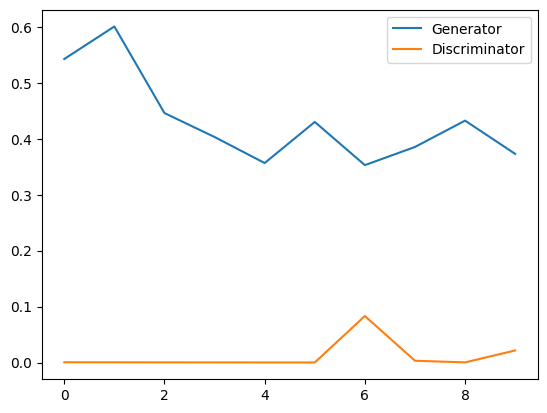

In [51]:
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.legend()
plt.show()

In [53]:
def evaluate(generator_model_path):

    generator = GeneratorResNet().to(device)
    generator.load_state_dict(torch.load(generator_model_path))
    generator.eval()

    total_psnr, total_ssim = 0, 0
    count = 0

    epoch = int(generator_model_path.split("_epoch_")[1].split(".pth")[0])

    saved_images = 0

    for i, imgs in enumerate(dataloader):
      imgs_lr = Variable(imgs["lr"].type(Tensor))
      imgs_hr = Variable(imgs["hr"].type(Tensor))

      if saved_images >= 3:
            break

      with torch.no_grad():
          restored = generator(imgs_lr).cpu()

      high_res = imgs_hr.cpu()
      restored = restored.cpu()

      #print(f"High-res shape: {high_res.shape}, Restored shape: {restored.shape}")

       # Вирівнювання розмірів
      if high_res.shape != restored.shape:
        print(f"Aligning shapes: High-res {high_res.shape}, Restored {restored.shape}")
        restored = torch.nn.functional.interpolate(restored, size=high_res.shape[2:], mode='bilinear', align_corners=False)


      total_psnr += psnr(high_res.numpy(), restored.numpy(), data_range=1.0)
      total_ssim += ssim(
          high_res.numpy().transpose(0, 2, 3, 1),
          restored.numpy().transpose(0, 2, 3, 1),
          win_size=3,
          channel_axis=-1,
          data_range=1.0
      )
      count += 1
      saved_images += 1

    if count > 0:
        avg_psnr = total_psnr / count
        avg_ssim = total_ssim / count
        result = f"Average PSNR: {avg_psnr:.4f}, Average SSIM: {avg_ssim:.4f}\n"
        print(result)

        with open("./data/result/evaluation_results.txt", "a") as f:
            f.write(f"Model: {generator_model_path}\n")
            f.write(result)

In [54]:
def evaluate_epoch_models():

    model_dir = './data/saved_models/'

    model_files = sorted([
        f for f in os.listdir(model_dir)
        if f.startswith("generator_epoch_") and f.endswith(".pth")
    ])

    for model_file in model_files:
        model_path = os.path.join(model_dir, model_file)
        print(f"\nОцінка моделі: {model_path}")
        evaluate(generator_model_path=model_path)


In [55]:
evaluate_epoch_models()


Оцінка моделі: ./data/saved_models/generator_epoch_1.pth


<ipython-input-53-7681e5fdbf2e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(generator_model_path))


Average PSNR: 4.0212, Average SSIM: 0.0821


Оцінка моделі: ./data/saved_models/generator_epoch_10.pth
Average PSNR: 10.9238, Average SSIM: 0.4517


Оцінка моделі: ./data/saved_models/generator_epoch_2.pth
Average PSNR: 5.9073, Average SSIM: 0.1645


Оцінка моделі: ./data/saved_models/generator_epoch_3.pth
Average PSNR: 7.7428, Average SSIM: 0.2232


Оцінка моделі: ./data/saved_models/generator_epoch_4.pth
Average PSNR: 8.7818, Average SSIM: 0.2849


Оцінка моделі: ./data/saved_models/generator_epoch_5.pth
Average PSNR: 10.9449, Average SSIM: 0.3916


Оцінка моделі: ./data/saved_models/generator_epoch_6.pth
Average PSNR: 10.6691, Average SSIM: 0.4109


Оцінка моделі: ./data/saved_models/generator_epoch_7.pth
Average PSNR: 12.2734, Average SSIM: 0.5597


Оцінка моделі: ./data/saved_models/generator_epoch_8.pth
Average PSNR: 11.6177, Average SSIM: 0.4153


Оцінка моделі: ./data/saved_models/generator_epoch_9.pth
Average PSNR: 11.6901, Average SSIM: 0.4981



In [61]:
# Define model and load model checkpoint
generator = GeneratorResNet().to(device)
generator.load_state_dict(torch.load('./data/saved_models/result/generator.pth'))
generator.eval()

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Prepare input
image_tensor = Variable(transform(Image.open('./data/img_align_celeba/default_class/000001.jpg'))).to(device).unsqueeze(0)

# Upsample image
with torch.no_grad():
    #sr_image = denormalize(generator(image_tensor)).cpu()
    sr_image = generator(image_tensor).cpu()

# Save image
fn = './data/img_align_celeba/default_class/000001.jpg'.split("/")[-1]
save_image(sr_image, f"./data/result/sr-{fn}")

<ipython-input-61-63c75218435b>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load('./data/saved_models/result/generator.pth'))
